##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%pip install pandas
#%pip install matplotlib
#%pip install scikit-learn
#%pip install seaborn
#%pip install numpy
#%pip install imbalanced-learn
#%pip install xgboost
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

In [ ]:
# All libraries used
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

# Abstract
###### In this project, our aim is to predict customer propensity to purchase insurance at Singlife, with the aim of refining marketing strategies. The following illustrates our project's outline.


*   Preparing the data
*   Data visualization
*   Training the data
*   Modelling of data
*   Conclusion

# **PREPARING THE DATA**#

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
filepath = './data/catB_train.parquet'
#filepath = '/content/drive/MyDrive/data/catB_train.parquet'
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

In [ ]:
df=pd.read_parquet(filepath)
df.head

<bound method NDFrame.head of           clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   
...           ...       ...           ...     ...       ...          ...   
11284  3363260248      None     Singapore       P    LAPSED   2016-08-01   
11964  c3509f0aef   Chinese     Singapore       P    ACTIVE   1990-03-20   
5390   6e44cfb3e7   Chinese     Singapore       P    ACTIVE   2007-12-31   
860    dd4e362f9f    Others     Singapore       P    ACTIVE   2007-09-01   
15795  3788d06ec7    Indian     Singapore       P    ACTIVE   2011-10-24   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_bor

In [ ]:
numRows, numCols = df.shape
print(numRows)
print(numCols)

Exploratory Data Analysis (EDA) - To gain better idea of the distribution of the data

###### After analysing, it is observed that there are 17992 rows of data and 304 variables (1 target variable and 303 features). We also attempted to gain better idea of some categories as indicated below. Afterwards, we also noticed that there are some missing values as indicated as NaN which suggests cleaning of data is required.

In [ ]:
# General Client Information

# race_desc: Race
df['race_desc'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('race_desc')
plt.ylabel('Count')
plt.title('Distribution of Race')
plt.show()

# ctrycode_desc: Location of Clients
df['ctrycode_desc'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('ctrycode_desc')
plt.ylabel('Count')
plt.title('Distribution of Country code ')
plt.show()

# clttype: Customer status
df['clttype'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('clttype')
plt.ylabel('Count')
plt.title('Distribution of Customer Status ')
plt.show()

# stat_flag: Flag indicating active/matured/lapsed
df['stat_flag'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('stat_flag')
plt.ylabel('Count')
plt.title('Distribution of policy status flag')
plt.show()

# min_occ_date: Date of client first interaction with company - To obtain years joined
plt.figure(figsize=(8, 6))
df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], errors='coerce')
df['no._years_joined'] = 2024 - df['min_occ_date'].dt.year  # Created no._years_joined
sb.histplot(df['no._years_joined'], kde=True, bins=10)
plt.title("Histogram of number of years joined")
plt.show()

df = df.drop(columns = "min_occ_date") # Drop because created no._years_joined

#cltdob_fix: Date of birth - To obtain Age
plt.figure(figsize=(8, 6))
currentYear = 2024
df['cltage']= currentYear - pd.to_datetime(df['cltdob_fix'], errors='coerce').dt.year
sb.histplot(df['cltage'], kde=True, bins=10, color='pink')
plt.title("Distribution of Age")
plt.show()

df = df.drop(columns = "cltdob_fix") # Drop because created cltage

# cltsex_fix: Gender
df['cltsex_fix'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('cltsex_fix')
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.show()



<Axes: xlabel='f_purchase_lh', ylabel='count'>

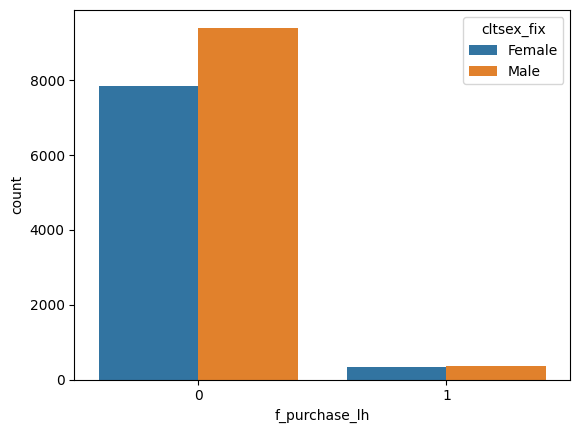

In [ ]:
# Analyse relationship between gender and f_purchase_lh (target)
# Convert f_purchase_lh from float to categorical
df['f_purchase_lh'] = df['f_purchase_lh'].replace({np.nan: 0, 1.0: 1}).astype('int').astype('category')
sb.countplot(data=df, x='f_purchase_lh', hue='cltsex_fix')

In [ ]:
df.head(3)

Not sure if the following code block still needed?

In [ ]:
# flg_is_borderline_standard: Flag for Borderline Standard Risk
df['flg_is_borderline_standard'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('flg_is_borderline_standard')
plt.ylabel('Count')
plt.title('Distribution of Borderline Standard Risk Clients')
plt.show()

# flg_is_rental_flat: Indicates if the client lives in a rental flat
df['flg_is_rental_flat'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('flg_is_rental_flat')
plt.ylabel('Count')
plt.title('Distribution of Clients ')
plt.show()

# flg_has_health_claim: Flag for clients with health insurance claims.
df['flg_has_health_claim'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('flg_is_rental_flat')
plt.ylabel('Count')
plt.title('Distribution of Clients with health insurance claims')
plt.show()

# Client Risk and Status Indicators
riskAndStatus_columns = df.iloc[:, 7:17]
for col in riskAndStatus_columns.columns:
    selected_column = df[col]
    category_counts = selected_column.value_counts()
    print(f"Category Counts for {col}:\n", category_counts)

# Client Consent and Communication Preferences
consentAndCommunication_columns = df.iloc[:, 17:23]
for col in consentAndCommunication_columns.columns:
    selected_column = df[col]
    category_counts = selected_column.value_counts()
    print(f"Category Counts for {col}:\n", category_counts)

# Demographic and Household Information
demoAndHH_columns = df.iloc[:, 23:27]
for col in demoAndHH_columns.columns:
    selected_column = df[col]
    category_counts = selected_column.value_counts()
    print(f"Category Counts for {col}:\n", category_counts)

Check for NA values:
(i) If feature has too many missing values, feature to be dropped
(ii) If feature has a few missing values, rows with these missing values to be removed
(iii) Remaining features to be imputed

In [ ]:
# Checking for NA values
toDrop_columns = []
toRemove_rows = []
toImpute_columns = []

threshold1 = 50
threshold2 = 3000

missingValues = df.isna().sum()
for variableName, count in missingValues.items():
    if count > 0:
        print(f"Column '{variableName}' has {count} missing values.")

        # Features with <50 missing values will have rows removed
        if count < threshold1:
            toRemove_rows.append(variableName)

        # Features with >3000 missing values will be dropped due to too many missing values
        elif count > threshold2:
            toDrop_columns.append(variableName)

        # Remaining features are to be imputed
        else:
            toImpute_columns.append(variableName)

print(str(len(toRemove_rows)) + " features where rows with missing values shall be removed")
print(str(len(toDrop_columns)) + " features to be dropped")
print(str(len(toImpute_columns)) + " features where missing values will be interpolated")

print(f"Number of rows before in df: {len(df)}")

# Drop rows with missing values
for col in toRemove_rows:
    if col is None:
        print("Skipping None column")
        continue

    if col not in df.columns:
        print(f"Column '{col}' not found in DataFrame")
        continue

    # Remove rows with missing values in the specified column
    df.dropna(subset=[col], inplace=True)

print(f"Number of rows after in df: {len(df)}")

# Drop columns
df = df.drop(columns=toDrop_columns)


print("Number of features left = " + str(df.shape[1]))


Column 'race_desc' has 3996 missing values.
Column 'ctrycode_desc' has 20 missing values.
Column 'cltsex_fix' has 23 missing values.
Column 'flg_substandard' has 1014 missing values.
Column 'flg_is_borderline_standard' has 1014 missing values.
Column 'flg_is_revised_term' has 1014 missing values.
Column 'flg_is_rental_flat' has 1014 missing values.
Column 'flg_has_health_claim' has 1014 missing values.
Column 'flg_has_life_claim' has 1014 missing values.
Column 'flg_gi_claim' has 1014 missing values.
Column 'flg_is_proposal' has 1014 missing values.
Column 'flg_with_preauthorisation' has 1014 missing values.
Column 'flg_is_returned_mail' has 1014 missing values.
Column 'is_consent_to_mail' has 1014 missing values.
Column 'is_consent_to_email' has 1014 missing values.
Column 'is_consent_to_call' has 1014 missing values.
Column 'is_consent_to_sms' has 1014 missing values.
Column 'is_valid_dm' has 1014 missing values.
Column 'is_valid_email' has 1014 missing values.
Column 'is_housewife_r

Handling the remaining features to be imputed
(toImpute_columns)


1.   Categorical variables and flag variables: Replace NA with mode
2.   Numerical variables: KNN Imputer



In [ ]:
# Conversion of flag variables to categorical values
for col in toImpute_columns:

    # Set NA values of toImpute_columns to -1
    df[col].fillna(-1, inplace=True)

    # Convert only flag variables to categorical
    unique_values = df[col].unique()
    if set(unique_values) == {0., -1, 1.} or set(unique_values) == {0., -1,} or set(unique_values) == {-1, 1.}:
      df[col] = df[col].replace({0.0: 0, 1.0: 1, -1: -1}).astype('int').astype('category') #Convert to categorical values (0,1,-1) where -1 are NA


toHandle_flags = []
toHandle_others = []
for col in toImpute_columns:
    if df[col].dtypes == "category":
        toHandle_flags.append(col)
    else:
        toHandle_others.append(col)

print(toHandle_flags)  # flag features
print(toHandle_others)  # features to impute excluding flag features


# Replace all -1 values back to NA values
df.replace(-1, np.nan, inplace=True)



In [ ]:
# Check for the non-numeric values for features in toHandle_others
for col in toHandle_others:
    if df[col].dtype == 'O':  # Check if column has object (string) type
        non_numeric_values = df[col].loc[~pd.to_numeric(df[col], errors='coerce').notna()].unique()
        if len(non_numeric_values) > 0:
            print(f"Column '{col}' has non-numeric values: {non_numeric_values}")
    else:
        coltype = df[col].dtype
        print(f"Column '{col}' has data type: {coltype}")

# Hence we can only interpolate features "hh_20", "hh_size" and "pop_20"
# "hh_size_est" and "annual_income_est" to be converted to categorical features

canInterpolate = ['hh_20', 'pop_20', 'hh_size']
df['hh_size_est'] = df['hh_size_est'].astype('category')
df['annual_income_est'] = df["annual_income_est"].astype('category')

print(df['hh_size_est'])
print(df['annual_income_est'])


#Interpolation of numerical features
knn_imputer = KNNImputer(n_neighbors=5)
df[canInterpolate] = knn_imputer.fit_transform(df[canInterpolate])


# Replace the missing values within categorical features with the most frequent category (mode)
df['hh_size_est'] = df['hh_size_est'].fillna(df['hh_size_est'].mode()[0])
df['annual_income_est'] = df['annual_income_est'].fillna(df['annual_income_est'].mode()[0])

for col in toHandle_flags:
    df[col] = df[col].fillna(df[col].mode()[0])

Data Conversion (One-hot encoding for categorical variables, except target variable)



In [ ]:
# Identifying categorical and numerical variables
categorical_variables = []
numerical_variables = []
for column in df.columns:
    unique_values = df[column].unique()
    if 2 < len(unique_values) < 10 :
        print(column)
        print(unique_values)

    elif len(unique_values) <= 2:
        categorical_variables.append(column)

    else:
        numerical_variables.append(column)


categorical_variables.extend(['clttype', 'stat_flag', 'hh_size_est', 'annual_income_est'])
numerical_variables.extend(['ape_grp_de05ae', 'sumins_grp_de05ae', 'prempaid_grp_de05ae'])

# clntnum does not tell us information, hence drop column
df = df.drop('clntnum', axis=1)
numerical_variables.remove('clntnum')

# ctrycode_desc is location, hence categorical
categorical_variables.append('ctrycode_desc')
numerical_variables.remove('ctrycode_desc')

#n_months_last_bought_products
print(df['n_months_last_bought_products'].unique()) # negative values, NA values (came from the '-1' being set to NA earlier)
df.loc[df['n_months_last_bought_products'] < 0, 'n_months_last_bought_products'] = None # set negative values to NA


# Type casting
for col in categorical_variables:
    df[col] = df[col].astype('category')

for col in numerical_variables:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Final check for NA values
missing = df.isna().sum()
for variableName, count in missing.items():
    if count > 0:
        print(f"Column '{variableName}' has {count} missing values.")

df = df.dropna() # Drop NA values in 'n_months_last_bought_products'
df.shape


clttype
['P' 'G' 'C']
stat_flag
['ACTIVE' 'LAPSED' 'MATURED']
flg_substandard
[ 0. nan  1.]
flg_is_borderline_standard
[ 0. nan  1.]
flg_is_revised_term
[ 0. nan  1.]
flg_is_rental_flat
[ 0. nan  1.]
flg_has_health_claim
[ 0. nan  1.]
flg_has_life_claim
[ 0. nan  1.]
flg_gi_claim
[ 0. nan  1.]
flg_is_proposal
[ 0. nan  1.]
flg_with_preauthorisation
[ 0. nan  1.]
flg_is_returned_mail
[ 0. nan  1.]
is_consent_to_mail
[ 0.  1. nan]
is_consent_to_email
[ 0.  1. nan]
is_consent_to_call
[ 0.  1. nan]
is_consent_to_sms
[ 0.  1. nan]
is_valid_dm
[ 1.  0. nan]
is_valid_email
[ 1.  0. nan]
is_housewife_retiree
[ 0. nan  1.]
is_sg_pr
[ 1.  0. nan]
is_class_1_2
[ 1.  0. nan]
hh_size_est
['1' '3' '4' '>4' '2' None '0']
annual_income_est
['C.60K-100K' 'D.30K-60K' 'A.ABOVE200K' 'B.100K-200K' 'E.BELOW30K' None]
ape_grp_de05ae
[Decimal('0.00') Decimal('120.00') Decimal('238.56') Decimal('360.48')
 Decimal('1274.40') Decimal('852.72') Decimal('282.24')]
sumins_grp_de05ae
[Decimal('0.00') Decimal('27000.

(0, 219)

In [ ]:
# One-hot encoding for categorical features as labels do not have orders

# Exclude target variable ('f_purchase_lh') as it does not have to be label-encoded
categorical_variables.remove('f_purchase_lh')
print('f_purchase_lh' in categorical_variables)


df_encoded = pd.get_dummies(df, columns = categorical_variables)

In [ ]:
# Save df_encoded for easier usage of cleaned data
print(df_encoded.shape)
df_encoded.to_csv("df_encoded", index=False)

Treat imbalanced dataset (SMOTE)

In [ ]:
# read df_encoded
df_encoded=pd.read_csv('df_encoded')

X = df_encoded.drop('f_purchase_lh', axis=1)
y = df_encoded['f_purchase_lh']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) # X_val and y_val are validation sets

print('Before:', Counter(y_train))
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
print('After:', Counter(y_train))

Before: Counter({0: 13784, 1: 560})
After: Counter({1: 13784, 0: 13784})


Feature Selection


1.   Fisher Score
2.   Decision Tree



In [ ]:
# Feature selection using Fisher Score
k_best = SelectKBest(score_func=f_classif, k='all')  # 'all' to get scores for all features
k_best.fit(X_train, y_train)

fisher_scores = k_best.scores_
variable_names = X_train.columns

fisher_scores_df = pd.DataFrame({'Feature': variable_names, 'Fisher Score': fisher_scores})
fisher_scores_df = fisher_scores_df.sort_values(by='Fisher Score', ascending=False)
print(fisher_scores_df)

threshold =  500  # Fisher score below 500 are considered low scores, above 500 are considered high scores

# Obtain indices of features above the threshold
highFisher_indices = [i for i, score in enumerate(k_best.scores_) if score > threshold]

# Obtain list of features with low Fisher score
highFisher_variables = [variable_names[i] for i in highFisher_indices]
imptFeatures=[]
for feature in highFisher_variables:
    imptFeatures.append(feature)

print(len(variable_names))
print("Important features: ")
print(imptFeatures)
print(len(imptFeatures))


                                  Feature  Fisher Score
214                    f_ever_bought_gi_0   9813.923977
81                n_months_last_bought_gi   5218.815833
288          annual_income_est_E.BELOW30K   4963.103720
136                         is_valid_dm_0   4779.667662
138                      is_valid_email_0   4529.101099
..                                    ...           ...
263  n_months_last_bought_ltc_1280bf_9999           NaN
264  n_months_last_bought_inv_dcd836_9999           NaN
265   n_months_last_bought_lh_d0adeb_9999           NaN
290      ctrycode_desc_Bosnia-Herzegovina           NaN
308                  ctrycode_desc_Sweden           NaN

[315 rows x 2 columns]
315
Important features: 
['n_months_last_bought_products', 'sumins_grp_70e1dd', 'ape_839f8a', 'sumins_507c37', 'prempaid_839f8a', 'n_months_last_bought_839f8a', 'n_months_last_bought_gi', 'n_months_last_bought_grp_1581d7', 'n_months_last_bought_grp_caa6ff', 'cltsex_fix_Male', 'flg_substandard_0', 'flg_g

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [146 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 190 197
 198 199 200 201 202 207 216 217 222 231 262 263 264 265 290 308] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
# Feature Selection using Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_

# Sort features according to their importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 50 features
top_features = importance_df.head(50)
top_feature_names = top_features['Feature'].tolist()

print(importance_df)
print(top_features)
print(top_feature_names)

                                Feature  Importance
81              n_months_last_bought_gi    0.314716
144                      is_class_1_2_0    0.077016
145                      is_class_1_2_1    0.075671
106                   cltsex_fix_Female    0.075018
129                is_consent_to_mail_1    0.044882
..                                  ...         ...
178             prempaid_lh_d0adeb_0.00    0.000000
179             prempaid_gi_a10d1b_0.00    0.000000
180             prempaid_gi_29d435_0.00    0.000000
181             prempaid_gi_856320_0.00    0.000000
314  ctrycode_desc_Unknown Country Code    0.000000

[315 rows x 2 columns]
                             Feature  Importance
81           n_months_last_bought_gi    0.314716
144                   is_class_1_2_0    0.077016
145                   is_class_1_2_1    0.075671
106                cltsex_fix_Female    0.075018
129             is_consent_to_mail_1    0.044882
130            is_consent_to_email_0    0.038677
107      

In [ ]:
# List of Important features

# Convert the lists to sets
impt_features_set = set(imptFeatures)
top_features_set = set(top_feature_names)

# Find the union of the importance features determined by Fisher Score and Decision Tree
union_features = impt_features_set.union(top_features_set)
selected_features = list(union_features)

print(len(selected_features))


84


In [ ]:
selected_features

['sumins_507c37',
 'cltage',
 'is_sg_pr_0',
 'is_valid_dm_1',
 'hh_size_est_>4',
 'f_ever_bought_grp_fe5fb8_0',
 'annual_income_est_B.100K-200K',
 'n_months_last_bought_grp_1581d7',
 'f_ever_bought_grp_1581d7_0',
 'n_months_last_bought_grp_fe5fb8',
 'flg_latest_being_lapse_0',
 'f_ever_bought_grp_94baec_1',
 'f_retail_0',
 'f_ever_bought_lh_e22a6a_0',
 'sumins_grp_caa6ff',
 'is_consent_to_email_0',
 'n_months_last_bought_grp_70e1dd',
 'hh_size_est_4',
 'sumins_grp_70e1dd',
 'is_consent_to_mail_1',
 'n_months_last_bought_839f8a',
 'annual_income_est_D.30K-60K',
 'tot_inforce_pols',
 'n_months_last_bought_lh_e22a6a',
 'hh_size_est_3',
 'f_ever_bought_e22a6a_0',
 'hh_size',
 'f_ever_bought_ltc_43b9d5_0',
 'prempaid_839f8a',
 'is_class_1_2_0',
 'f_ever_bought_grp_caa6ff_0',
 'n_months_last_bought_c4bda5',
 'f_ever_bought_gi_1',
 'cltsex_fix_Male',
 'is_consent_to_call_1',
 'n_months_last_bought_507c37',
 'is_valid_email_1',
 'is_consent_to_sms_1',
 'f_ever_bought_grp_945b5a_0',
 'flg_is_bo

In [ ]:
# Manipulating the data to only include the selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# So now, we are working with X_train_selected, y_train, X_val_selected, y_val

#Decision Tree

In [ ]:
# set seed
seed = 69
X_train_selected, X_val_selected, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

train accuracy:  1.0
val accuracy:  0.928053541550474
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3458
           1       0.11      0.14      0.12       128

    accuracy                           0.93      3586
   macro avg       0.54      0.55      0.54      3586
weighted avg       0.94      0.93      0.93      3586



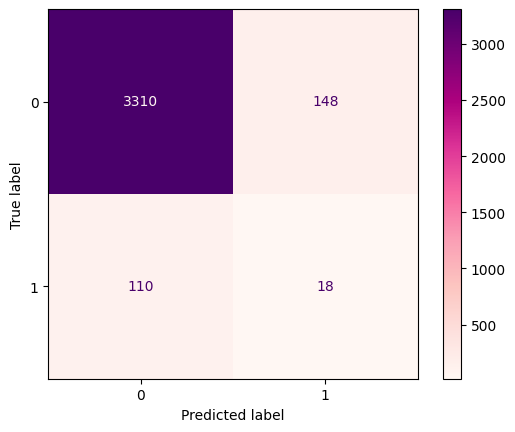

In [ ]:
# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_selected, y_train)
print("train accuracy: ", dt_clf.score(X_train_selected, y_train))
print("val accuracy: ", dt_clf.score(X_val_selected, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val_selected)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot(cmap='RdPu')

#KNN

train accuracy:  0.9609592861126603
val accuracy:  0.9623535973229225
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3458
           1       0.11      0.14      0.12       128

    accuracy                           0.93      3586
   macro avg       0.54      0.55      0.54      3586
weighted avg       0.94      0.93      0.93      3586



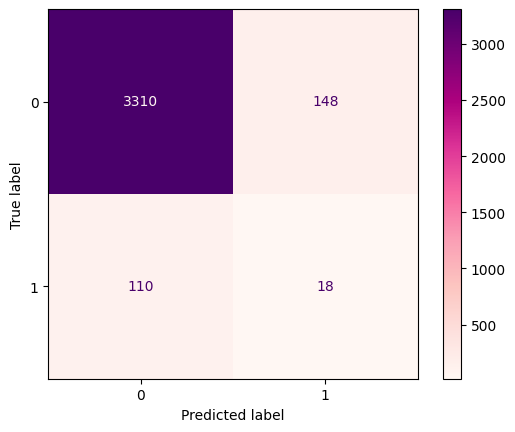

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_selected, y_train)
print("train accuracy: ", knn_clf.score(X_train_selected, y_train))
print("val accuracy: ", knn_clf.score(X_val_selected, y_val))

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val_selected)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot(cmap='RdPu')

#XGBoost with Cross Validation

In [ ]:
# Define XGBoost model
xgb_model=xgb.XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, object="binary: logistic", random_state=42)

# 5-fold cross-validation
accuracies=cross_val_score(xgb_model, X, y, cv=5)

print("Accuracy:", np.mean(accuracies))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:46:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarn

Accuracy: 0.962409369771333


Text(0.5, 1.0, 'Cross-Validation Results')

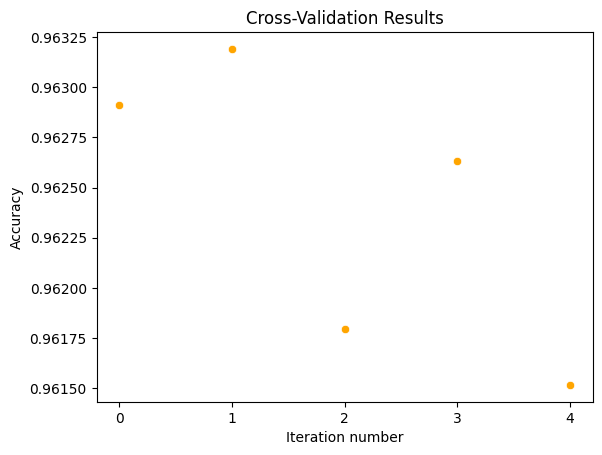

In [ ]:
# Plot to display accuracies
sb.scatterplot(accuracies, color="orange")
plt.xticks([0,1,2,3,4])
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Results")

In [ ]:
import pickle

# Save model
with open('xgb_model.pkl', 'wb') as f:
  pickle.dump(xgb_model, f)

#Analysis

XGB model performed the best in terms of accuracy. This is mainly because XGBoost is an ensemble method that can capture complex relationships in data. XGBoost is able to learn and generalize well to unseen data. Hence, we will use XGBoost to test the hidden data



## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
final_features = ['sumins_507c37',
 'cltage',
 'is_sg_pr_0',
 'is_valid_dm_1',
 'hh_size_est_>4',
 'f_ever_bought_grp_fe5fb8_0',
 'annual_income_est_B.100K-200K',
 'n_months_last_bought_grp_1581d7',
 'f_ever_bought_grp_1581d7_0',
 'n_months_last_bought_grp_fe5fb8',
 'flg_latest_being_lapse_0',
 'f_ever_bought_grp_94baec_1',
 'f_retail_0',
 'f_ever_bought_lh_e22a6a_0',
 'sumins_grp_caa6ff',
 'is_consent_to_email_0',
 'n_months_last_bought_grp_70e1dd',
 'hh_size_est_4',
 'sumins_grp_70e1dd',
 'is_consent_to_mail_1',
 'n_months_last_bought_839f8a',
 'annual_income_est_D.30K-60K',
 'tot_inforce_pols',
 'n_months_last_bought_lh_e22a6a',
 'hh_size_est_3',
 'f_ever_bought_e22a6a_0',
 'hh_size',
 'f_ever_bought_ltc_43b9d5_0',
 'prempaid_839f8a',
 'is_class_1_2_0',
 'f_ever_bought_grp_caa6ff_0',
 'n_months_last_bought_c4bda5',
 'f_ever_bought_gi_1',
 'cltsex_fix_Male',
 'is_consent_to_call_1',
 'n_months_last_bought_507c37',
 'is_valid_email_1',
 'is_consent_to_sms_1',
 'f_ever_bought_grp_945b5a_0',
 'flg_is_borderline_standard_1',
 'f_ever_bought_lh_839f8a_0',
 'f_ever_bought_gi_0',
 'sumins_lh_f852af',
 'is_consent_to_email_1',
 'is_valid_dm_0',
 'clttype_G',
 'hh_size_est_2',
 'no._years_joined',
 'stat_flag_ACTIVE',
 'is_consent_to_mail_0',
 'n_months_last_bought_gi',
 'annual_income_est_E.BELOW30K',
 'cltsex_fix_Female',
 'f_ever_bought_839f8a_0',
 'f_elx_1',
 'f_hold_839f8a_0',
 'n_months_last_bought_32c74c',
 'ape_507c37',
 'n_months_last_bought_products',
 'f_ever_bought_507c37_0',
 'hh_20',
 'f_ever_bought_grp_70e1dd_0',
 'flg_is_proposal_0',
 'is_housewife_retiree_0',
 'n_months_last_bought_grp_caa6ff',
 'f_hold_507c37_0',
 'prempaid_lh_947b15',
 'f_ever_bought_grp_6fc3e6_0',
 'f_mindef_mha_0',
 'is_class_1_2_1',
 'f_ever_bought_lh_507c37_0',
 'f_ever_bought_grp_fe5fb8_1',
 'flg_gi_claim_0',
 'clttype_P',
 'is_valid_email_0',
 'hh_size_est_1',
 'f_retail_1',
 'annual_income_est_C.60K-100K',
 'ape_839f8a',
 'annual_income_est_A.ABOVE200K',
 'ape_ltc_43b9d5',
 'pop_20',
 'flg_substandard_0',
 'f_mindef_mha_1']

categorical_variables = ['cltsex_fix',
 'is_dependent_in_at_least_1_policy',
 'flg_latest_being_lapse',
 'flg_latest_being_cancel',
 'ape_gi_42e115',
 'ape_ltc_1280bf',
 'ape_inv_dcd836',
 'ape_lh_d0adeb',
 'ape_gi_a10d1b',
 'ape_gi_29d435',
 'ape_gi_856320',
 'ape_gi_058815',
 'ape_32c74c',
 'sumins_gi_42e115',
 'sumins_ltc_1280bf',
 'sumins_inv_dcd836',
 'sumins_lh_d0adeb',
 'sumins_grp_22decf',
 'sumins_gi_a10d1b',
 'sumins_gi_29d435',
 'sumins_lh_e22a6a',
 'sumins_grp_e04c3a',
 'sumins_grp_fe5fb8',
 'sumins_gi_856320',
 'sumins_grp_94baec',
 'sumins_gi_058815',
 'sumins_32c74c',
 'prempaid_gi_42e115',
 'prempaid_ltc_1280bf',
 'prempaid_inv_dcd836',
 'prempaid_lh_d0adeb',
 'prempaid_gi_a10d1b',
 'prempaid_gi_29d435',
 'prempaid_gi_856320',
 'prempaid_gi_058815',
 'prempaid_32c74c',
 'ape_d0adeb',
 'ape_gi',
 'f_hold_839f8a',
 'f_hold_e22a6a',
 'f_hold_d0adeb',
 'f_hold_c4bda5',
 'f_hold_ltc',
 'f_hold_507c37',
 'f_hold_gi',
 'sumins_e22a6a',
 'sumins_d0adeb',
 'sumins_gi',
 'prempaid_d0adeb',
 'prempaid_gi',
 'f_ever_bought_839f8a',
 'f_ever_bought_e22a6a',
 'f_ever_bought_d0adeb',
 'f_ever_bought_c4bda5',
 'f_ever_bought_ltc',
 'f_ever_bought_507c37',
 'f_ever_bought_gi',
 'n_months_last_bought_d0adeb',
 'f_ever_bought_ltc_1280bf',
 'f_ever_bought_grp_6fc3e6',
 'f_ever_bought_grp_de05ae',
 'f_ever_bought_inv_dcd836',
 'f_ever_bought_grp_945b5a',
 'f_ever_bought_grp_6a5788',
 'f_ever_bought_ltc_43b9d5',
 'f_ever_bought_grp_9cdedf',
 'f_ever_bought_lh_d0adeb',
 'f_ever_bought_grp_1581d7',
 'f_ever_bought_grp_22decf',
 'f_ever_bought_lh_507c37',
 'f_ever_bought_lh_839f8a',
 'f_ever_bought_inv_e9f316',
 'f_ever_bought_grp_caa6ff',
 'f_ever_bought_grp_fd3bfb',
 'f_ever_bought_lh_e22a6a',
 'f_ever_bought_grp_70e1dd',
 'f_ever_bought_grp_e04c3a',
 'f_ever_bought_grp_fe5fb8',
 'f_ever_bought_grp_94baec',
 'f_ever_bought_grp_e91421',
 'f_ever_bought_lh_f852af',
 'f_ever_bought_lh_947b15',
 'f_ever_bought_32c74c',
 'n_months_last_bought_ltc_1280bf',
 'n_months_last_bought_inv_dcd836',
 'n_months_last_bought_lh_d0adeb',
 'f_elx',
 'f_mindef_mha',
 'f_retail',
 'clttype',
 'stat_flag',
 'hh_size_est',
 'annual_income_est',
 'ctrycode_desc']

numerical_variables= ['min_occ_date',
 'cltdob_fix',
 'hh_20',
 'pop_20',
 'hh_size',
 'n_months_last_bought_products',
 'tot_inforce_pols',
 'ape_grp_6fc3e6',
 'ape_grp_945b5a',
 'ape_grp_6a5788',
 'ape_ltc_43b9d5',
 'ape_grp_9cdedf',
 'ape_grp_1581d7',
 'ape_grp_22decf',
 'ape_lh_507c37',
 'ape_lh_839f8a',
 'ape_inv_e9f316',
 'ape_grp_caa6ff',
 'ape_grp_fd3bfb',
 'ape_lh_e22a6a',
 'ape_grp_70e1dd',
 'ape_grp_e04c3a',
 'ape_grp_fe5fb8',
 'ape_grp_94baec',
 'ape_grp_e91421',
 'ape_lh_f852af',
 'ape_lh_947b15',
 'sumins_grp_6fc3e6',
 'sumins_grp_945b5a',
 'sumins_grp_6a5788',
 'sumins_ltc_43b9d5',
 'sumins_grp_9cdedf',
 'sumins_grp_1581d7',
 'sumins_lh_507c37',
 'sumins_inv_e9f316',
 'sumins_grp_caa6ff',
 'sumins_grp_fd3bfb',
 'sumins_grp_70e1dd',
 'sumins_grp_e91421',
 'sumins_lh_f852af',
 'sumins_lh_947b15',
 'prempaid_grp_6fc3e6',
 'prempaid_grp_945b5a',
 'prempaid_grp_6a5788',
 'prempaid_ltc_43b9d5',
 'prempaid_grp_9cdedf',
 'prempaid_grp_1581d7',
 'prempaid_grp_22decf',
 'prempaid_lh_507c37',
 'prempaid_lh_839f8a',
 'prempaid_inv_e9f316',
 'prempaid_grp_caa6ff',
 'prempaid_grp_fd3bfb',
 'prempaid_lh_e22a6a',
 'prempaid_grp_70e1dd',
 'prempaid_grp_e04c3a',
 'prempaid_grp_fe5fb8',
 'prempaid_grp_94baec',
 'prempaid_grp_e91421',
 'prempaid_lh_f852af',
 'prempaid_lh_947b15',
 'ape_839f8a',
 'ape_e22a6a',
 'ape_c4bda5',
 'ape_ltc',
 'ape_507c37',
 'sumins_839f8a',
 'sumins_c4bda5',
 'sumins_ltc',
 'sumins_507c37',
 'prempaid_839f8a',
 'prempaid_e22a6a',
 'prempaid_c4bda5',
 'prempaid_ltc',
 'prempaid_507c37',
 'n_months_last_bought_839f8a',
 'n_months_last_bought_e22a6a',
 'n_months_last_bought_c4bda5',
 'n_months_last_bought_ltc',
 'n_months_last_bought_507c37',
 'n_months_last_bought_gi',
 'n_months_last_bought_grp_6fc3e6',
 'n_months_last_bought_grp_de05ae',
 'n_months_last_bought_grp_945b5a',
 'n_months_last_bought_grp_6a5788',
 'n_months_last_bought_ltc_43b9d5',
 'n_months_last_bought_grp_9cdedf',
 'n_months_last_bought_grp_1581d7',
 'n_months_last_bought_grp_22decf',
 'n_months_last_bought_lh_507c37',
 'n_months_last_bought_lh_839f8a',
 'n_months_last_bought_inv_e9f316',
 'n_months_last_bought_grp_caa6ff',
 'n_months_last_bought_grp_fd3bfb',
 'n_months_last_bought_lh_e22a6a',
 'n_months_last_bought_grp_70e1dd',
 'n_months_last_bought_grp_e04c3a',
 'n_months_last_bought_grp_fe5fb8',
 'n_months_last_bought_grp_94baec',
 'n_months_last_bought_grp_e91421',
 'n_months_last_bought_lh_f852af',
 'n_months_last_bought_lh_947b15',
 'n_months_last_bought_32c74c',
 'ape_grp_de05ae',
 'sumins_grp_de05ae',
 'prempaid_grp_de05ae']

In [ ]:
def clean_data(df):
  # Checking for NA values
  toImpute_columns = []
  canInterpolate=[]
  knn_imputer = KNNImputer(n_neighbors=5)

  missingValues = df.isna().sum()
  for variableName, count in missingValues.items():
      if count > 0:
        toImpute_columns.append(variableName)

  # Conversion of flag variables to categorical values
  for col in toImpute_columns:

      if col in categorical_variables:
        df[col] = df[col].astype('category') #Convert to categorical values (0,1,-1) where -1 are NA
        df[col] = df[col].fillna(df[col].mode()[0])

      else:
        canInterpolate.append(col)
        df[col] = df[col].astype(float)

  df[canInterpolate] = knn_imputer.fit_transform(df[canInterpolate])
  df_encoded = pd.get_dummies(df, columns = categorical_variables)
  df_selected = df_encoded[final_features]

  return df_selected


In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
  X = clean_data(hidden_data)
  y_pred=xgb_model.predict(X)
  result = list(y_pred)

  return result

  '''DO NOT REMOVE THIS FUNCTION.

  The function accepts a dataframe as input and return an iterable (list)
  of binary classes as output.

  The function should be coded to test on hidden data
  and should include any preprocessing functions needed for your model to perform.

  All relevant code MUST be included in this function.'''


##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!